In [12]:
# modules
# import basics
import os
import re
import csv
import json
import time
# import requests
import numpy as np
import pandas as pd

from time import sleep
from datetime import datetime, timedelta 
from dotenv import load_dotenv
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
#from requests.auth import HTTPBasicAuth

# text processing dependencies
# from bs4 import BeautifulSoup
# from boilerpy3 import extractors

# mysql dependencies
import mysql.connector

In [13]:
# initialize variables

load_dotenv(override=True)

# mysql credentials
PASSWORD = os.getenv("PASSWORD")
USER = os.getenv("USER")

In [14]:
# connect to db
import mysql.connector

mydb = mysql.connector.connect(
  host="127.0.0.1",
  user=USER,
  password=PASSWORD,
  database="mpp21"
)

mycursor = mydb.cursor()

In [139]:
# read newspaper info 

newspapers = {}

with open('./newspapers-collected.csv', 'r') as f:
        reader = csv.reader(f)
        for r in reader:
            newspapers[r[0]] = r[1]

In [140]:
# db methods
def select_within_range(curs, db, n):
    
    curs.execute("SELECT article_id, title, date FROM articles WHERE newspaper = '" + n + "' AND date >= '" + timeframe_start + "' AND date <= '" + timeframe_end + "'") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "title": r[1],
            "date": r[2]
        }
    
    return arts

In [141]:
newspapers

{'AFR': 'Australian Financial Review',
 'DT': 'The Daily Telegraph (London)',
 'GM': 'The Globe and Mail (Canada)',
 'NYT': 'The New York Times - International Edition',
 'NZH': 'The New Zealand Herald',
 'SMH': 'Sydney Morning Herald (Australia)',
 'TDP': 'The Dominion Post (Wellington',
 'TG': 'The Guardian (London)',
 'TS': 'The Toronto Star',
 'USA': 'USA Today'}

In [142]:
weeks = []

timeframe_start = datetime.date(datetime(2018,1,1))
timeframe_end = datetime.date(datetime(2018,6,30))

dt = timeframe_start

while dt <= timeframe_end:
    
    weeks.append((dt, dt + timedelta(days=6))) # (start, end)
    dt += timedelta(days=7) # move to next week

In [143]:
len(weeks)

26

In [144]:
timeframe_start = '2018-01-01'#datetime.strftime(datetime(2018,1,1), '%Y-%m-%d')
timeframe_end = '2018-06-30'#datetime.strftime(datetime(2018,3,1), '%Y-%m-%d')

In [145]:
# get articles for newspaper n in range

articles = {}
for n in newspapers.keys():
    articles[n] = {}

for n in articles.keys():
    articles[n] = select_within_range(mycursor, mydb, n)

In [146]:
def group_by_week(n):
    
    group = {}

    ctr = 1 # week

    for w in range(len(weeks)):
        group["week_" +str(w + 1) + ""] = []

    for week in weeks:
        for i in articles[n].keys():

            if articles[n][i]["date"] >= week[0] and articles[n][i]["date"] <= week[1]:
                dc = {"id": i,
                      "date": articles[n][i]["date"],
                      "title": articles[n][i]["title"]                    
                }
                group["week_" +str(ctr) + ""].append(dc)
        ctr += 1
        
    return group

In [147]:
groups = {}
for n in articles.keys():
    groups[n] = group_by_week(n)

In [148]:
titles = {}


for n in groups.keys():
    titles[n] = {}
    for w in groups[n].keys():
        titles[n][w] = []
        for entry in groups[n][w]:
            titles[n][w].append(entry["title"])

In [149]:
def get_cosine_similarity_week(docs): # docs = list of titles

    # doc term matrix
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform(docs)

    return cosine_similarity(sparse_matrix, sparse_matrix)


def display_cosine_similarity_results(res):
    
    results = [round(r, 3) for r in res.flatten()]
        
    return sorted(results) 

In [151]:
#result = get_cosine_similarity_week(titles["TS"]["week_10"])
#results = display_cosine_similarity_results(result) # returned as set
#results

In [152]:
def cos_sim(x, y):
    
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform([x, y])

    return cosine_similarity(sparse_matrix, sparse_matrix)[0] 
    # returns first row i.e. x vs y (second is y vs x)

In [124]:
duplicate_titles = {}

In [153]:
def get_similarity_distribution_weeks():
    
    cosines = []
    
    for n in newspapers.keys(): # for each newspaper
        #duplicate_titles[n] = {}
        for w in groups[n].keys(): # for each week
            #duplicate_titles[n][w] = []
            pairs_in = []
            for a1 in groups[n][w]: # for articles within that week
                for a2 in groups[n][w]: # compared with articles within that week
                    try:
                        cs = cos_sim(a1["title"], a2["title"]) # get similarity between articles' titles
                        if a1["id"] != a2["id"]: # if it's not the same article
                            if sorted((a1["id"], a2["id"])) not in pairs_in: # if the pairs has not already been compared
                                pairs_in.append(sorted((a1["id"], a2["id"]))) # add pair
                                cosines.append(cs[1]) # add similarity index
                    except:
                        print("error")
                        pass
                    
    return cosines

In [154]:
cosines_period = get_similarity_distribution_weeks()

In [190]:
pd.DataFrame(cosines_period).to_csv("cosines_2018.csv", header=None, index=None)

In [278]:
def display_aggregated_similarity(agg):
    
    #plt.figure(figsize=(8,8),facecolor='red',edgecolor='blue')
    fig,ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    
    a = list(agg)
    ax.hist(a, bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
            histtype="step",  color="#87111d", alpha=0.45, edgecolor="#87111d", linewidth=3.2)
    #ax.set_title("histogram of aggregated cosine similarity for 6 months (all newspapers)", fontsize=24)
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xlabel('cosine similarity score', fontsize=20)
    ax.set_ylabel('frequency of similarity score values', fontsize=20)
    ax.set_yticks([0,10,100,1000,10000])
    ax.set_yticklabels([0,10,100,1000,10000], fontsize=20)
    ax.set_xticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize=20) 
    plt.yscale("log")   

    #plt.xlim(40, 160)
#     plt.ylim(0, 30000)
   ## ax.spines['top'].set_visible(False)
    ##ax.spines['right'].set_visible(False)

    #plt.grid(True)
    plt.show()
    
    return 

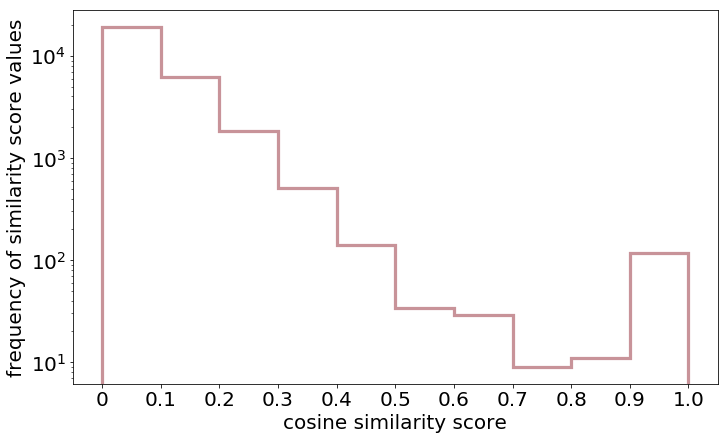

In [279]:
display_aggregated_similarity(cosines_period)

In [134]:
def get_similarities_over_threshold(t):

    #all_titles = {}
    cosines = []
    tres_arts = []

    #dups = 0
    #ttls = []
    for n in newspapers.keys():
        #all_titles[n] = {}
        for w in groups[n].keys(): # for each week
            #all_titles[n][w] = []
            pairs_in = []
            for a1 in groups[n][w]: # for articles within that week
                for a2 in groups[n][w]:
                    try:
                        cs = cos_sim(a1["title"], a2["title"])
                        if cs[1] >= t and cs[1] < 0.8:# and cs[1] < 0.9:

                            if a1["id"] != a2["id"]:

                                if sorted((a1["id"], a2["id"])) not in pairs_in:
                                    #all_titles[n][w].append((a1, a2))
                                    pairs_in.append(sorted((a1["id"], a2["id"])))
                                    #ttls.append(a1["title"])
                                    cosines.append(cs[1])
                                    tres_arts.append((a1, a2))
                                   # print(cs[1], a1["id"], a2["id"])
                    except:
                        pass
            #dups += len(pairs_in)
    return cosines, tres_arts

In [135]:
cosines_threshold, threshold_articles = get_similarities_over_threshold(0.7)

0.7436508613923036 TG_7571 TG_7570
0.7899531467283196 TG_7571 TG_7572
0.7882407813680823 TG_7874 TG_7875
0.7896267896853093 TG_7037 TG_8471
0.7064063285320279 TG_8034 TG_8035
0.7832178030674114 TG_6628 TG_6675
0.777777777777778 TG_8294 TG_8144
0.777777777777778 TG_8144 TG_8292
0.777777777777778 TG_8144 TG_8293
0.7915543352055223 TG_8462 TG_8459
0.7091389668510999 TG_6767 TG_6761
0.7915543352055223 TG_8461 TG_8459
0.7091389668510999 TG_6769 TG_6761
0.7091389668510999 TG_6761 TG_6768
0.7915543352055223 TG_8460 TG_8459
0.7035264706814485 DT_3160 DT_3249
0.7905694150420948 TS_3652 TS_3613
0.7500000000000002 TS_3763 TS_3764
0.7272727272727274 GM_2425 GM_2424


In [138]:
# ct = 1
# for i in threshold_articles:
#     print(ct)
#     print(i[0]["title"])
#     print
#     print(i[1]["title"])
#     print("------------------------------------------------")
#     ct += 1


In [111]:
threshold_articles[9]

({'date': datetime.date(2018, 3, 22),
  'id': 'TG_11988',
  'title': "'They were given an inch and took 100 miles': readers on Cambridge Analytica, Facebook and privacy;We asked you whether you're thinking of deleting your Facebook account and to share your thoughts on data privacy"},
 {'date': datetime.date(2018, 3, 21),
  'id': 'TG_11989',
  'title': "Are you leaving Facebook? Share your concerns on privacy with us;We'd like to hear your thoughts on Facebook, privacy and the Cambridge Analytica files"})

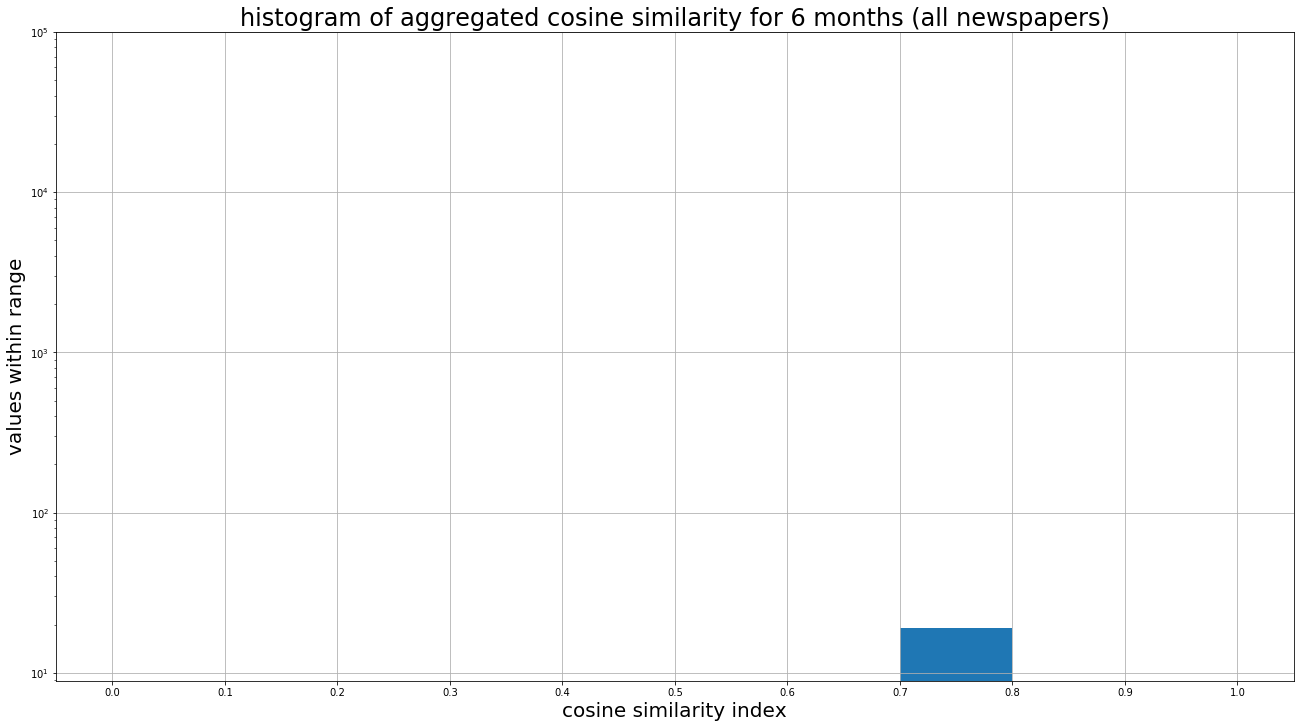

In [136]:
display_aggregated_similarity(cosines_threshold)

In [82]:
cosines_threshold

[0.700404195972475,
 0.733358797622569,
 0.733358797622569,
 0.7041868508280461,
 0.7171087882915775,
 0.7222222222222224,
 0.775217091182553,
 0.7071067811865475,
 0.7462025072446364]

In [68]:
# db methods
def select_test(curs, db, a):
    
    curs.execute("SELECT article_id, title, date, content FROM articles WHERE article_id = '" + a +"'") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "title": r[1],
            "date": r[2],
            "content": r[3]
        }
    
    return arts[r[0]]

In [35]:
aggregated_similarities = []

for n in titles.keys():
    for w in titles[n].keys():
        res = get_cosine_similarity_week(titles[n][w]) # get similarities for newspaper n during week w
        # format them
        results = [round(r, 3) for r in res.flatten()] # sorted() ?
        
        for i in results:
            aggregated_similarities.append(i)

In [47]:
total_articles = 0
for i in articles.keys():
    total_articles += len(articles[i])

In [266]:
#display_aggregated_similarity(aggregated_similarities)

## SAME FOR MONTHS

In [267]:
months = [
    (datetime.date(datetime(2018,1,1)), datetime.date(datetime(2018,1,31))),
     (datetime.date(datetime(2018,2,1)), datetime.date(datetime(2018,2,28))),
     (datetime.date(datetime(2018,3,1)), datetime.date(datetime(2018,3,31))),
     (datetime.date(datetime(2018,4,1)), datetime.date(datetime(2018,4,30))),
     (datetime.date(datetime(2018,5,1)), datetime.date(datetime(2018,5,31))),
     (datetime.date(datetime(2018,6,1)), datetime.date(datetime(2018,6,30))),   
    
]


In [268]:
def group_by_month(n):
    
    group = {}

    ctr = 1 # week

    for m in range(len(months)):
        group["month_" +str(m + 1) + ""] = []

    for month in months:
        for i in articles[n].keys():

            if articles[n][i]["date"] >= month[0] and articles[n][i]["date"] <= month[1]:
                dc = {"id": i,
                      "date": articles[n][i]["date"],
                      "title": articles[n][i]["title"]                    
                }
                group["month_" +str(ctr) + ""].append(dc)
        ctr += 1
        
    return group

In [281]:
groups_months = {}
for n in articles.keys():
    groups_months[n] = group_by_month(n)

In [319]:
all_titles_months = {}
cosines_months = []
ttls2 = [] 
for n in newspapers.keys():
    all_titles_months[n] = {}
    for m in groups_months[n].keys(): # for each month
        all_titles_months[n][m] = []
        pairs_in = []
        for a1 in groups_months[n][m]: # for articles within that month
            for a2 in groups_months[n][m]:
                cs = cos_sim(a1["title"], a2["title"])
                if cs[1] >= 0.7:# and cs[1] < 0.9:

                    if a1["id"] != a2["id"]:

                        if sorted((a1["id"], a2["id"])) not in pairs_in:

                            all_titles_months[n][m].append((a1, a2))
                            pairs_in.append(sorted((a1["id"], a2["id"])))
                            ttls2.append(a1["title"])
                            cosines_months.append(cs[1])


In [320]:
len(ttls2)

213

In [321]:
len(set(ttls2))

180

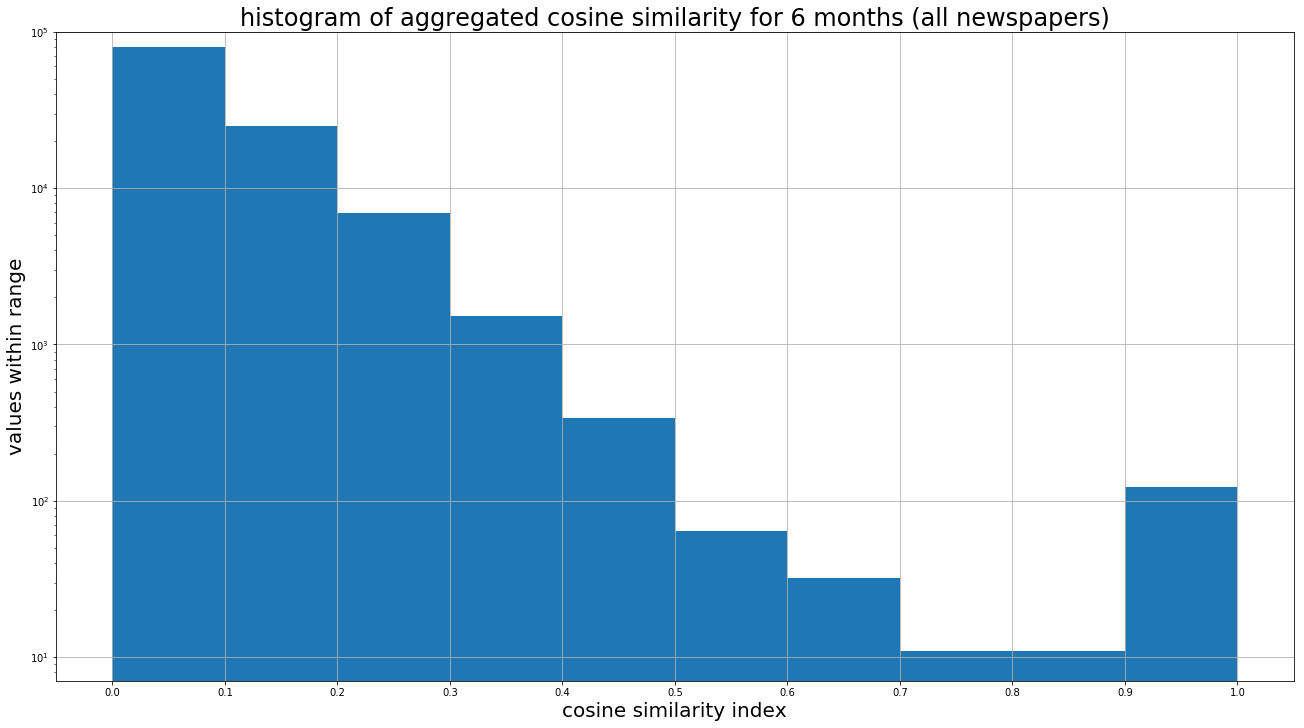

In [312]:
display_aggregated_similarity(cosines_months)

In [302]:
len(groups_months["TS"]["month_6"])

55

In [300]:
50 * 101 / 2

2525.0

In [301]:
2016 + 3570 + 8778 + 9870 + 8778 + 2525

35537

In [303]:
total_months = 0
for n in newspapers.keys():
    for m in groups_months[n].keys():
        total_months += len(groups_months[n][m]) * (len(groups_months[n][m]) + 1) /2
        

In [304]:
total_months

116950.0

In [6]:
newspapers

{'AFR': 'Australian Financial Review',
 'DT': 'The Daily Telegraph (London)',
 'GM': 'The Globe and Mail (Canada)',
 'NYT': 'The New York Times - International Edition',
 'NZH': 'The New Zealand Herald',
 'SMH': 'Sydney Morning Herald (Australia)',
 'TDP': 'The Dominion Post (Wellington',
 'TG': 'The Guardian (London)',
 'TS': 'The Toronto Star',
 'USA': 'USA Today'}

In [ ]:
# db methods
def select_test(curs, db, n):
    
    curs.execute("SELECT article_id, title, date FROM articles WHERE newspaper = '" + n + "' AND date >= '" + timeframe_start + "' AND date <= '" + timeframe_end + "'") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "title": r[1],
            "date": r[2]
        }
    
    return arts